# Códigos para Plotar Informações de Emissões
## Plotando Jan-pt-d04 
## Opções EDGAR+PT 
* A) PT_ED-100I
* B) PT-20_ED-100I
* C) PT_ED-100I-20T
* D) PT-20_ED-100I-20T

Carregar saídas SMOKE para demonstrar perfis de emissões, considerando região de RMSP e Piracicaba

In [1]:
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import datetime as dt
%matplotlib inline

## *Entradas*
* Selecionar arquivos de origem para preparar figuras.
* Inicializar variáveis para figuras.

### Parametrização dos arquivos de entrada

Ajustar diretório que contem os arquivos, nomes de rodadas, e shapefiles a serem plotados

In [2]:
directory = str('D:/Mestrado/1.Resultados/Emissoes/')
wrfdir = str('D:/Mestrado/1.Resultados/Meteorologia/')
mes   = ['jan','jul']
grade = ['d01_27km','d02_9km','d03_3km','d04_1km']
data  = ['20150109','20150724']
datawrf  = ['01-09','07-24']
modelagens = ['PT_ED-100I']#,'PT_ED-100I-20T','PT-20_ED-100I','PT-20_ED-100I-20T']
shapes = ['pirashape']
spinup = 48
run_len = 24*7

## Abrir arquivos SMOKE

In [3]:
mods = []
for mod in modelagens:
    mods.append(xr.open_dataset(directory+'pt.'+mes[0]+'.'+grade[3]+
                                '/egts_l.'+data[0]+
                                '.9.'+grade[3][:3]+'.htapv2.'+
                                mod+'.ncf'))

## Abrir arquivo WRF para buscar valores de LAT / LON

In [4]:
nc_wrf = Dataset(wrfdir+'arqWRF/'+mes[0]+'/wrf_fnl_pira_rizzieri2016_nudge_'+mes[0]+
                 '/wrfout_'+grade[3][:3]+'_2015-'+datawrf[0]+'_00%3A00%3A00')

## Preparar coordenadas para XArray
* DATAS
* ALTITUDE
* LATITUDE
* LONGITUDE

In [5]:
# DATAS
dates = [dt.datetime.strptime(str(mods[0].attrs['SDATE']),'%Y%j')]
for i in range(1,mods[0].dims['TSTEP']):
    dates.append(dates[0]+dt.timedelta(hours=i))

# LATITUDE
# LONGITUDE
croplat = int((nc_wrf.dimensions['south_north'].size-mods[0].dims['ROW'])/2)
croplon = int((nc_wrf.dimensions['south_north'].size-mods[0].dims['ROW'])/2)
lats      = nc_wrf.variables['XLAT'][0,croplat:-croplat,croplat:-croplat]
longs     = nc_wrf.variables['XLONG'][0,croplon:-croplon,croplon:-croplon]

# PLOT CORNERS
llcrnrlon = np.min(longs)      #longitude of lower left hand corner of the selected map domain.
llcrnrlat = np.min(lats)       #latitude of upper right hand corner of the desired map domain (degrees).
urcrnrlon = np.max(longs)      #longitude of upper right hand corner of the selected map domain.
urcrnrlat = np.max(lats)      #latitude of upper right hand corner of the selected map domain.

coordlat  = np.linspace(llcrnrlat,urcrnrlat,num=mods[0].dims['ROW'])
coordlon  = np.linspace(llcrnrlon,urcrnrlon,num=mods[0].dims['COL'])

# ADJUSTMENTS
for m in mods:
    m.coords['TSTEP'] = dates
    m.coords['ROW'] = coordlat
    m.coords['COL'] = coordlon
    m.rename({'ROW': 'LAT', 'COL': 'LON'}, inplace=True)
    for var in m.variables:
        if 'units' in m.variables[var].attrs:
            m.variables[var].attrs['units'] = m.variables[var].attrs['units'].split()[0]
for i in range(0,len(mods)):
    mods[i] = mods[i].isel(TSTEP=slice(spinup,spinup+run_len),LAY=slice(0,1))
weekd=[]
for d in mods[0].TSTEP.dt.weekday:
    if d < 5:
        weekd.append('Weekday')
    else:
        weekd.append('Weekend')

## Preparar variáveis agregadas de emissões 
O objetivo é comparar com o inventário de emissões da CETESB  
https://cetesb.sp.gov.br/ar/wp-content/uploads/sites/28/2013/12/RQAR-2015.pdf

* **CO  --> Variables ['CO']**
* **HC  --> VOC --> Variable ['VOC']**  
    *ALD2, ALDX, BENZENE, ETH, ETHA, ETOH, FORM, IOLE, ISOP, MEOH, NAPH, NVOL, OLE, PAR, SOAALK, TERP, TOL, UNR, XYLMN*
* **NOx --> Variable['NOX']**  
    *HONO, NO, NO2*
* **MP  --> Variable['MP']**  
    *PAL, PCA, PCL, PFE, PH2O, PK, PMG, PMN, PMOTHR, PNA, PNCOM, PNH4, PNO3, PSI, PSO4, PTI, PMC, PEC, POC, PMFINE*
* **SOx --> Variable['SOx']**  
    *SO2, SULF*

In [6]:
VOCvar = ['ALD2' , 'ALDX', 'BENZENE', 'ETH'   , 'ETHA'  , 
          'ETOH' , 'FORM', 'IOLE'   , 'ISOP'  , 'MEOH'  , 
          'NAPH' , 'NVOL', 'OLE'    , 'PAR'   , 'SOAALK', 
          'TERP' , 'TOL' , 'UNR'    , 'XYLMN']
NOxvar = ['HONO' , 'NO'  , 'NO2']
MPvar  = ['PAL'  , 'PCA' , 'PCL'    , 'PFE'   , 'PH2O'  , 
          'PK'   , 'PMG' , 'PMN'    , 'PMOTHR', 'PNA'   ,
          'PNCOM', 'PNH4', 'PNO3'   , 'PSI'   , 'PSO4'  , 
          'PTI'  , 'PMC' , 'PEC'    , 'POC'   , 'PMFINE']
SOxvar = ['SO2'  , 'SULF']
cVOC = []
cNOx = []
cMP  = []
cSOx = []
for m in range(0, len(mods)):
# VOC
    #Inicializar
    cVOC.append(mods[m].variables[VOCvar[0]]+mods[m].variables[VOCvar[1]])
    #Unir todas as variáveis
    for i in range(2,len(VOCvar)):
        if VOCvar[i] in mods[m].variables:
            cVOC[m] += mods[m].variables[VOCvar[i]]
    # Assign variable
    mods[m] = mods[m].assign(variables={'VOC':(cVOC[m])})
    mods[m].variables['VOC'].attrs['units'] = mods[m].variables[VOCvar[0]].attrs['units']
    mods[m].variables['VOC'].attrs['long_name'] = 'VOC Calculado'
# NOX
    #Inicializar
    cNOx.append(mods[m].variables[NOxvar[0]]+mods[m].variables[NOxvar[1]])
    #Unir todas as variáveis
    for i in range(2,len(NOxvar)):
        if NOxvar[i] in mods[m].variables:
            cNOx[m] += mods[m].variables[NOxvar[i]]
    # Assign variable
    mods[m] = mods[m].assign(variables={'NOx':(cNOx[m])})
    mods[m].variables['NOx'].attrs['units'] = mods[m].variables[NOxvar[0]].attrs['units']
    mods[m].variables['NOx'].attrs['long_name'] = 'NOx calculado'
# MP
    #Inicializar
    cMP.append(mods[m].variables[MPvar[0]]+mods[m].variables[MPvar[1]])
    #Unir todas as variáveis
    for i in range(2,len(MPvar)):
        if MPvar[i] in mods[m].variables:
            cMP[m] += mods[m].variables[MPvar[i]]
    # Assign variable
    mods[m] = mods[m].assign(variables={'MP':(cNOx[m])})
    mods[m].variables['MP'].attrs['units'] = mods[m].variables[MPvar[0]].attrs['units']
    mods[m].variables['MP'].attrs['long_name'] = 'MP calculado'
# SOx
    #Inicializar
    cSOx.append(mods[m].variables[SOxvar[0]]+mods[m].variables[SOxvar[1]])
    # Assign variable
    mods[m] = mods[m].assign(variables={'SOx':(cSOx[m])})
    mods[m].variables['SOx'].attrs['units'] = mods[m].variables[SOxvar[0]].attrs['units']
    mods[m].variables['SOx'].attrs['long_name'] = 'SOx calculado'

## Figuras por poluente

### Material Particulado

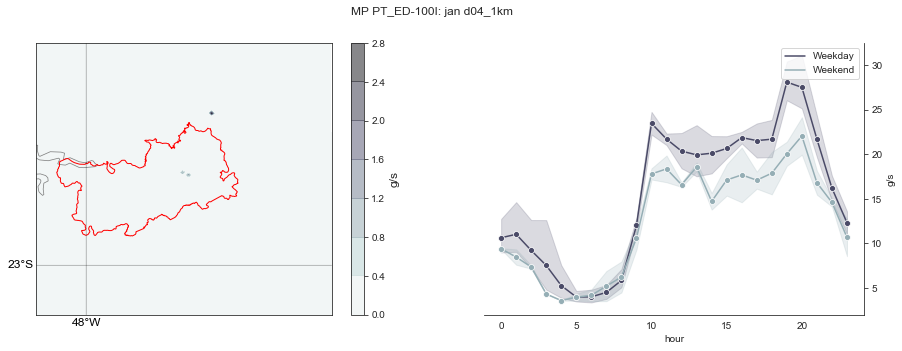

In [8]:
param = 'MP'
mesplt = mes[0]
gradeplt = grade[3]
for i in range(0, len(modelagens)):
# PLOT COLORMAP
    fig, axes = plt.subplots(ncols=2, figsize=(15,5)) #gridspec_kw = {'width_ratios':[2, 1]})
    fig.suptitle(param+' '+modelagens[i]+': '+mesplt+' '+gradeplt, fontsize=12)
    map = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=axes[0])           
    paramplot = map.contourf(longs,       #X specify the (x) coordinates of the surface
                    lats,                 #Y specify the (y) coordinates of the surface
                    np.squeeze(mods[i][param][:,0,:,:].mean(dim='TSTEP')), 
                    antialiased = False,
                    cmap=plt.cm.bone_r,
                    alpha=0.5,
                    vmin=0)#,
                    #vmax=int(np.ceil(mods[0][param][:,0,:,:].max())),
                    #levels=np.arange(0,int(np.ceil(mods[0][param][:,0,:,:].max()))))
## DRAW COAST, COUNTRY, STATES, PARALLELS, MERIDIANS
    map.drawcoastlines(linewidth=0.75, color='gray')
    #map.drawcountries(linewidth=1.0)
    map.drawstates(linewidth=1.0, color='gray')
    map.drawparallels(np.arange(-80., 81., 1), labels=[1,0,0,0], fontsize=12, linewidth=0.5)       
    map.drawmeridians(np.arange(-180., 181., 1), labels=[0,0,0,1], fontsize=12, linewidth=0.5)
    #map.fillcontinents(color='coral',lake_color='aqua')
    #map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') 
## PLOT SHAPEFILES
    for s in shapes:
        map.readshapefile(wrfdir+'arqShape/'+s, s, color='r', linewidth=1.0) #Plot shapefile
## MAP ARCGIS
    #map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= False, alpha=1.0)
## COLORBAR
    cbar = fig.colorbar(paramplot, ax=axes[0]) # Plot Colorbar
    cbar.set_label(mods[i].variables[param].attrs['units'], fontsize = 12, rotation=90)
    cbar.ax.tick_params(labelsize = 10)
## TITLE FOR SUBPLOT
    #axes[0].set_title(param)
# PLOT LINEPLOT
    sns.set_style('white')
    sns.despine(right=False, left=True, ax=axes[1])
    sns.lineplot(x=mods[i].TSTEP.dt.hour, y=mods[i].variables[param][:,0,:,:].sum(dim=['LAT', 'LON']), 
                           hue=weekd, hue_order=['Weekday','Weekend'], palette='bone', marker='o', ax=axes[1])
    axes[1].set_ylabel(mods[i].variables[param].attrs['units'])
    axes[1].yaxis.set_ticks_position('right')
    axes[1].yaxis.set_label_position('right')

### NOx

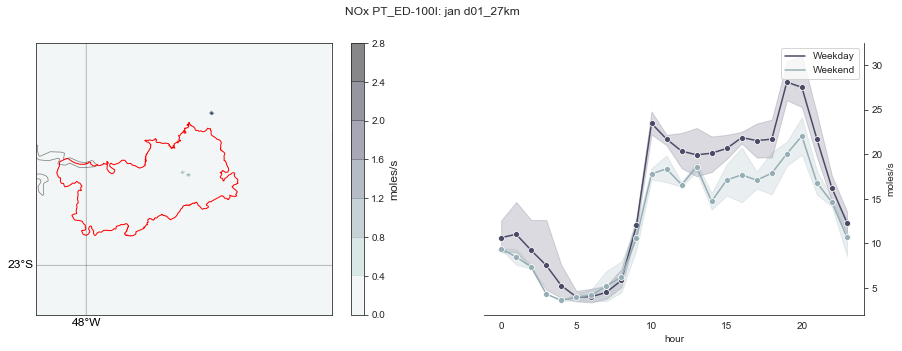

In [10]:
param = 'NOx'
mesplt = mes[0]
gradeplt = grade[0]
for i in range(0, len(modelagens)):
# PLOT COLORMAP
    fig, axes = plt.subplots(ncols=2, figsize=(15,5)) #gridspec_kw = {'width_ratios':[2, 1]})
    fig.suptitle(param+' '+modelagens[i]+': '+mesplt+' '+gradeplt, fontsize=12)
    map = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=axes[0])           
    paramplot = map.contourf(longs,       #X specify the (x) coordinates of the surface
                    lats,                 #Y specify the (y) coordinates of the surface
                    np.squeeze(mods[i][param][:,0,:,:].mean(dim='TSTEP')), 
                    antialiased = False,
                    cmap=plt.cm.bone_r,
                    alpha=0.5,
                    vmin=0)#,
                    #vmax=int(np.ceil(mods[0][param][:,0,:,:].max())),
                    #levels=np.arange(0,int(np.ceil(mods[0][param][:,0,:,:].max()))))
## DRAW COAST, COUNTRY, STATES, PARALLELS, MERIDIANS
    map.drawcoastlines(linewidth=0.75, color='gray')
    #map.drawcountries(linewidth=1.0)
    map.drawstates(linewidth=1.0, color='gray')
    map.drawparallels(np.arange(-80., 81., 1), labels=[1,0,0,0], fontsize=12, linewidth=0.5)       
    map.drawmeridians(np.arange(-180., 181., 1), labels=[0,0,0,1], fontsize=12, linewidth=0.5)
    #map.fillcontinents(color='coral',lake_color='aqua')
    #map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') 
## PLOT SHAPEFILES
    for s in shapes:
        map.readshapefile(wrfdir+'arqShape/'+s, s, color='r', linewidth=1.0) #Plot shapefile
## MAP ARCGIS
    #map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= False, alpha=1.0)
## COLORBAR
    cbar = fig.colorbar(paramplot, ax=axes[0]) # Plot Colorbar
    cbar.set_label(mods[i].variables[param].attrs['units'], fontsize = 12, rotation=90)
    cbar.ax.tick_params(labelsize = 10)
## TITLE FOR SUBPLOT
    #axes[0].set_title(param)
# PLOT LINEPLOT
    sns.set_style('white')
    sns.despine(right=False, left=True, ax=axes[1])
    sns.lineplot(x=mods[i].TSTEP.dt.hour, y=mods[i].variables[param][:,0,:,:].sum(dim=['LAT', 'LON']), 
                           hue=weekd, hue_order=['Weekday','Weekend'], palette='bone', marker='o', ax=axes[1])
    axes[1].set_ylabel(mods[i].variables[param].attrs['units'])
    axes[1].yaxis.set_ticks_position('right')
    axes[1].yaxis.set_label_position('right')

### VOC

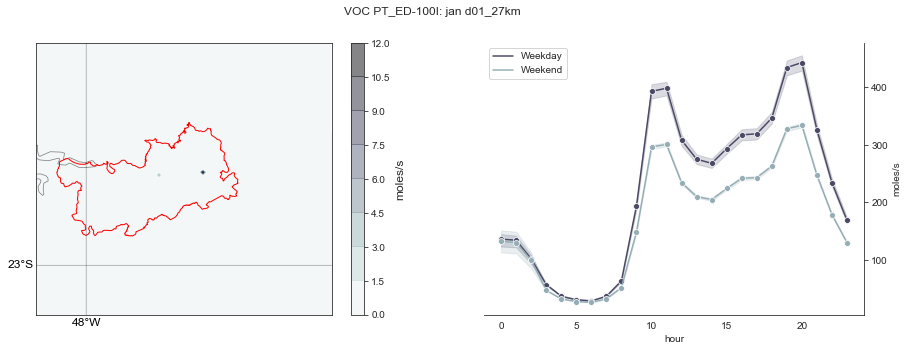

In [11]:
param = 'VOC'
mesplt = mes[0]
gradeplt = grade[0]
for i in range(0, len(modelagens)):
# PLOT COLORMAP
    fig, axes = plt.subplots(ncols=2, figsize=(15,5)) #gridspec_kw = {'width_ratios':[2, 1]})
    fig.suptitle(param+' '+modelagens[i]+': '+mesplt+' '+gradeplt, fontsize=12)
    map = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=axes[0])           
    paramplot = map.contourf(longs,       #X specify the (x) coordinates of the surface
                    lats,                 #Y specify the (y) coordinates of the surface
                    np.squeeze(mods[i][param][:,0,:,:].mean(dim='TSTEP')), 
                    antialiased = False,
                    cmap=plt.cm.bone_r,
                    alpha=0.5,
                    vmin=0)#,
                    #vmax=int(np.ceil(mods[0][param][:,0,:,:].max())),
                    #levels=np.arange(0,int(np.ceil(mods[0][param][:,0,:,:].max()))))
## DRAW COAST, COUNTRY, STATES, PARALLELS, MERIDIANS
    map.drawcoastlines(linewidth=0.75, color='gray')
    #map.drawcountries(linewidth=1.0)
    map.drawstates(linewidth=1.0, color='gray')
    map.drawparallels(np.arange(-80., 81., 1), labels=[1,0,0,0], fontsize=12, linewidth=0.5)       
    map.drawmeridians(np.arange(-180., 181., 1), labels=[0,0,0,1], fontsize=12, linewidth=0.5)
    #map.fillcontinents(color='coral',lake_color='aqua')
    #map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') 
## PLOT SHAPEFILES
    for s in shapes:
        map.readshapefile(wrfdir+'arqShape/'+s, s, color='r', linewidth=1.0) #Plot shapefile
## MAP ARCGIS
    #map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= False, alpha=1.0)
## COLORBAR
    cbar = fig.colorbar(paramplot, ax=axes[0]) # Plot Colorbar
    cbar.set_label(mods[i].variables[param].attrs['units'], fontsize = 12, rotation=90)
    cbar.ax.tick_params(labelsize = 10)
## TITLE FOR SUBPLOT
    #axes[0].set_title(param)
# PLOT LINEPLOT
    sns.set_style('white')
    sns.despine(right=False, left=True, ax=axes[1])
    sns.lineplot(x=mods[i].TSTEP.dt.hour, y=mods[i].variables[param][:,0,:,:].sum(dim=['LAT', 'LON']), 
                           hue=weekd, hue_order=['Weekday','Weekend'], palette='bone', marker='o', ax=axes[1])
    axes[1].set_ylabel(mods[i].variables[param].attrs['units'])
    axes[1].yaxis.set_ticks_position('right')
    axes[1].yaxis.set_label_position('right')

### SOx

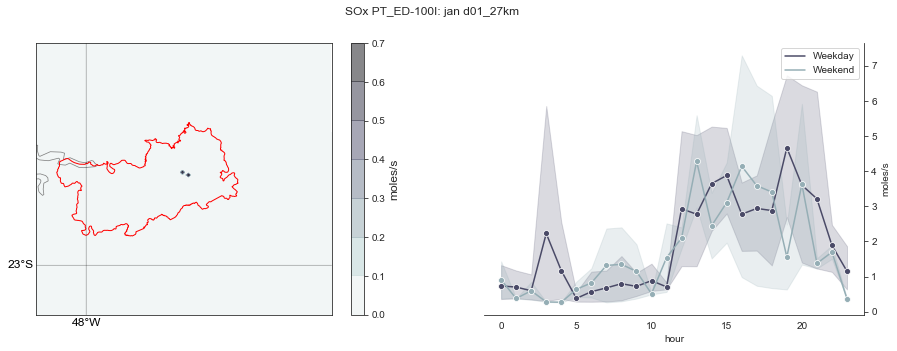

In [12]:
param = 'SOx'
mesplt = mes[0]
gradeplt = grade[0]
for i in range(0, len(modelagens)):
# PLOT COLORMAP
    fig, axes = plt.subplots(ncols=2, figsize=(15,5)) #gridspec_kw = {'width_ratios':[2, 1]})
    fig.suptitle(param+' '+modelagens[i]+': '+mesplt+' '+gradeplt, fontsize=12)
    map = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=axes[0])           
    paramplot = map.contourf(longs,       #X specify the (x) coordinates of the surface
                    lats,                 #Y specify the (y) coordinates of the surface
                    np.squeeze(mods[i][param][:,0,:,:].mean(dim='TSTEP')), 
                    antialiased = False,
                    cmap=plt.cm.bone_r,
                    alpha=0.5,
                    vmin=0)#,
                    #vmax=int(np.ceil(mods[0][param][:,0,:,:].max())),
                    #levels=np.arange(0,int(np.ceil(mods[0][param][:,0,:,:].max()))))
## DRAW COAST, COUNTRY, STATES, PARALLELS, MERIDIANS
    map.drawcoastlines(linewidth=0.75, color='gray')
    #map.drawcountries(linewidth=1.0)
    map.drawstates(linewidth=1.0, color='gray')
    map.drawparallels(np.arange(-80., 81., 1), labels=[1,0,0,0], fontsize=12, linewidth=0.5)       
    map.drawmeridians(np.arange(-180., 181., 1), labels=[0,0,0,1], fontsize=12, linewidth=0.5)
    #map.fillcontinents(color='coral',lake_color='aqua')
    #map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') 
## PLOT SHAPEFILES
    for s in shapes:
        map.readshapefile(wrfdir+'arqShape/'+s, s, color='r', linewidth=1.0) #Plot shapefile
## MAP ARCGIS
    #map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= False, alpha=1.0)
## COLORBAR
    cbar = fig.colorbar(paramplot, ax=axes[0]) # Plot Colorbar
    cbar.set_label(mods[i].variables[param].attrs['units'], fontsize = 12, rotation=90)
    cbar.ax.tick_params(labelsize = 10)
## TITLE FOR SUBPLOT
    #axes[0].set_title(param)
# PLOT LINEPLOT
    sns.set_style('white')
    sns.despine(right=False, left=True, ax=axes[1])
    sns.lineplot(x=mods[i].TSTEP.dt.hour, y=mods[i].variables[param][:,0,:,:].sum(dim=['LAT', 'LON']), 
                           hue=weekd, hue_order=['Weekday','Weekend'], palette='bone', marker='o', ax=axes[1])
    axes[1].set_ylabel(mods[i].variables[param].attrs['units'])
    axes[1].yaxis.set_ticks_position('right')
    axes[1].yaxis.set_label_position('right')